In [1]:
# Install necessary libraries (if not already installed)
%pip install transformers datasets peft evaluate scikit-learn tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install ipywidgets
%pip install jupyterlab_widgets

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import json
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.optim import AdamW

In [4]:
# Paths
DATASET_PATH = '/Users/rumenguin/Research/MERC/EmoReact/dataset.csv'
TRAIN_NAMES_PATH = '/Users/rumenguin/Research/MERC/EmoReact/Labels/Train_names.txt'
VAL_NAMES_PATH = '/Users/rumenguin/Research/MERC/EmoReact/Labels/Val_names.txt'
TEST_NAMES_PATH = '/Users/rumenguin/Research/MERC/EmoReact/Labels/Test_names.txt'
MODEL_NAME = 'distilbert-base-uncased'  # Good balance of performance and efficiency for Mac M1
SAVE_DIR = '/Users/rumenguin/Research/MERC/models/saved_model'

# Create save directory if it doesn't exist
os.makedirs(SAVE_DIR, exist_ok=True)

# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [5]:
# Load and preprocess the dataset
def load_video_names(file_path):
    with open(file_path, 'r') as f:
        # Remove quotes if present and strip whitespace
        return [line.strip().replace("'", "").replace('"', '') for line in f.readlines()]

# Load video names for train, val, and test sets
train_videos = load_video_names(TRAIN_NAMES_PATH)
val_videos = load_video_names(VAL_NAMES_PATH)
test_videos = load_video_names(TEST_NAMES_PATH)

print(f"Train videos: {len(train_videos)}")
print(f"Val videos: {len(val_videos)}")
print(f"Test videos: {len(test_videos)}")

# Load the dataset
df = pd.read_csv(DATASET_PATH)
print(f"Dataset shape: {df.shape}")

# Display first few rows to understand the data
df.head()

# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

Train videos: 432
Val videos: 303
Test videos: 367
Dataset shape: (1102, 6)
Missing values in each column:
ID              0
Video           0
Transcript     10
Behavior        0
Labels        138
Valence         0
dtype: int64


In [6]:
# Process Labels (emotions)
# Convert string representation of emotion labels to lists
def process_labels(labels):
    if pd.isna(labels) or labels == 'None' or labels == '':
        return []
    try:
        # Try to evaluate as a literal Python expression (list, tuple, etc.)
        return eval(labels)
    except:
        # If it's a simple string without brackets
        if isinstance(labels, str):
            return [label.strip() for label in labels.split(',')]
        return []

# Apply to the Labels column
df['Processed_Labels'] = df['Labels'].apply(process_labels)

# List all possible emotions
all_emotions = ['Curiosity', 'Uncertainty', 'Excitement', 'Happiness', 'Surprise', 'Disgust', 'Fear', 'Frustration']
print(f"All possible emotions: {all_emotions}")

All possible emotions: ['Curiosity', 'Uncertainty', 'Excitement', 'Happiness', 'Surprise', 'Disgust', 'Fear', 'Frustration']


In [7]:
# Convert Valence to numeric and handle missing values
df['Valence'] = pd.to_numeric(df['Valence'], errors='coerce')
# Fill missing valence with mean value
mean_valence = df['Valence'].mean()
df['Valence'] = df['Valence'].fillna(mean_valence)
print(f"Valence range: {df['Valence'].min()} to {df['Valence'].max()}")

# Create new column combining Transcript and Behavior
df['Combined_Text'] = df['Transcript'].fillna('') + ' ' + df['Behavior'].fillna('')
df['Combined_Text'] = df['Combined_Text'].str.strip()

# Handle cases where both transcript and behavior might be empty
df.loc[df['Combined_Text'] == '', 'Combined_Text'] = "No information available"


Valence range: 1.0 to 7.0


In [8]:
# Split dataset into train, val, test based on the video files
def get_video_name(video_path):
    return os.path.basename(video_path)

df['VideoName'] = df['Video'].apply(get_video_name)

train_df = df[df['VideoName'].isin(train_videos)]
val_df = df[df['VideoName'].isin(val_videos)]
test_df = df[df['VideoName'].isin(test_videos)]

print(f"Train set: {len(train_df)} samples")
print(f"Val set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")

Train set: 432 samples
Val set: 303 samples
Test set: 367 samples


In [9]:
from sklearn.preprocessing import MultiLabelBinarizer
# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=all_emotions)
mlb.fit([all_emotions])  # Ensure all classes are represented

# One-hot encode the labels
train_labels_encoded = mlb.transform(train_df['Processed_Labels'].tolist())
val_labels_encoded = mlb.transform(val_df['Processed_Labels'].tolist())
test_labels_encoded = mlb.transform(test_df['Processed_Labels'].tolist())

# Save the class mapping
with open(os.path.join(SAVE_DIR, 'emotion_labels.json'), 'w') as f:
    json.dump({idx: emotion for idx, emotion in enumerate(mlb.classes_)}, f)

In [10]:
# Create a custom dataset class
class EmotionDataset(Dataset):
    def __init__(self, texts, emotion_labels, valence_values, tokenizer, max_length=512):
        self.texts = texts
        self.emotion_labels = emotion_labels
        self.valence_values = valence_values
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        emotion_label = self.emotion_labels[idx]
        valence = self.valence_values[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        # Squeeze to remove batch dimension
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'emotion_labels': torch.FloatTensor(emotion_label),
            'valence': torch.FloatTensor([valence])
        }

In [11]:
from transformers import DistilBertModel
# Define the model
class EmotionValenceModel(nn.Module):
    def __init__(self, n_emotions, dropout_prob=0.3):
        super(EmotionValenceModel, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        
        # Freeze some layers of DistilBERT to reduce computational load and prevent overfitting
        modules = [self.distilbert.embeddings, *self.distilbert.transformer.layer[:2]]
        for module in modules:
            for param in module.parameters():
                param.requires_grad = False
        
        hidden_size = self.distilbert.config.hidden_size
        
        # Common layers
        self.dropout = nn.Dropout(dropout_prob)
        self.pre_classifier = nn.Linear(hidden_size, 256)
        self.activation = nn.ReLU()
        
        # Emotion classification head
        self.emotion_classifier = nn.Linear(256, n_emotions)
        
        # Valence regression head
        self.valence_regressor = nn.Linear(256, 1)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state[:, 0]  # Use [CLS] token representation
        
        x = self.dropout(hidden_state)
        x = self.pre_classifier(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        # Multi-label emotion classification (using sigmoid for multi-label)
        emotion_output = self.emotion_classifier(x)
        
        # Valence regression (value between 1-7)
        valence_output = self.valence_regressor(x)
        
        return emotion_output, valence_output


In [12]:
from transformers import DistilBertTokenizer
# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Create datasets
train_dataset = EmotionDataset(
    train_df['Combined_Text'].tolist(),
    train_labels_encoded,
    train_df['Valence'].tolist(),
    tokenizer
)

val_dataset = EmotionDataset(
    val_df['Combined_Text'].tolist(),
    val_labels_encoded,
    val_df['Valence'].tolist(),
    tokenizer
)

test_dataset = EmotionDataset(
    test_df['Combined_Text'].tolist(),
    test_labels_encoded,
    test_df['Valence'].tolist(),
    tokenizer
)

In [13]:
# Create data loaders
batch_size = 16  # Smaller batch size for M1 Mac

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize the model
n_emotions = len(all_emotions)
model = EmotionValenceModel(n_emotions)
model = model.to(device)

# Define loss functions
emotion_criterion = nn.BCEWithLogitsLoss()
valence_criterion = nn.MSELoss()

# Define optimizer with weight decay for regularization
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Learning rate scheduler
num_epochs = 80
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [14]:
# Training loop

def train_model(model, train_loader, val_loader, optimizer, scheduler, emotion_criterion, valence_criterion, num_epochs, device):
    # For tracking metrics
    history = {
        'train_emotion_loss': [],
        'train_valence_loss': [],
        'train_total_loss': [],
        'val_emotion_loss': [],
        'val_valence_loss': [],
        'val_total_loss': [],
        'val_micro_f1': [],
        'val_macro_f1': [],
        'val_valence_rmse': [],
        'val_accuracy': []  # Added accuracy tracking
    }
    
    # Alpha parameter for balancing losses (can be adjusted)
    alpha = 0.7  # Weight for emotion loss
    beta = 0.3   # Weight for valence loss
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        train_emotion_loss = 0
        train_valence_loss = 0
        train_total_loss = 0
        
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
        
        for batch_idx, batch in progress_bar:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            emotion_labels = batch['emotion_labels'].to(device)
            valence = batch['valence'].to(device)
            
            # Forward pass
            emotion_logits, valence_pred = model(input_ids, attention_mask)
            
            # Calculate losses
            e_loss = emotion_criterion(emotion_logits, emotion_labels)
            v_loss = valence_criterion(valence_pred, valence)
            
            # Weighted combined loss
            loss = alpha * e_loss + beta * v_loss
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            
            # Update metrics
            train_emotion_loss += e_loss.item()
            train_valence_loss += v_loss.item()
            train_total_loss += loss.item()
            
            # Update progress bar
            progress_bar.set_description(f"Training - Loss: {loss.item():.4f}")
        
        # Calculate average training losses
        avg_train_emotion_loss = train_emotion_loss / len(train_loader)
        avg_train_valence_loss = train_valence_loss / len(train_loader)
        avg_train_total_loss = train_total_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_emotion_loss = 0
        val_valence_loss = 0
        val_total_loss = 0
        
        all_emotion_preds = []
        all_emotion_labels = []
        all_valence_preds = []
        all_valence_labels = []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                emotion_labels = batch['emotion_labels'].to(device)
                valence = batch['valence'].to(device)
                
                emotion_logits, valence_pred = model(input_ids, attention_mask)
                
                e_loss = emotion_criterion(emotion_logits, emotion_labels)
                v_loss = valence_criterion(valence_pred, valence)
                loss = alpha * e_loss + beta * v_loss
                
                val_emotion_loss += e_loss.item()
                val_valence_loss += v_loss.item()
                val_total_loss += loss.item()
                
                # Convert logits to predictions
                emotion_preds = torch.sigmoid(emotion_logits).cpu().numpy() > 0.5  # Threshold for multi-label classification
                # Convert lists to numpy arrays for F1 calculation
                
                all_emotion_preds.extend(emotion_preds.astype(int).tolist())
                all_emotion_labels.extend(emotion_labels.cpu().numpy().astype(int).tolist())
                all_valence_preds.extend(valence_pred.cpu().numpy().flatten().tolist())
                all_valence_labels.extend(valence.cpu().numpy().flatten().tolist())
        
        # Calculate validation metrics
        avg_val_emotion_loss = val_emotion_loss / len(val_loader)
        avg_val_valence_loss = val_valence_loss / len(val_loader)
        avg_val_total_loss = val_total_loss / len(val_loader)
        
        # F1 scores for emotion classification
        #micro_f1 = f1_score(all_emotion_labels, all_emotion_preds, average='micro')
        # macro_f1 = f1_score(all_emotion_labels, all_emotion_preds, average='macro')
        # Convert to numpy arrays
        emotion_preds_np = np.array(all_emotion_preds)
        emotion_labels_np = np.array(all_emotion_labels)

        # F1 scores for multi-label emotion classification
        micro_f1 = f1_score(emotion_labels_np, emotion_preds_np, average='micro', zero_division=0)
        macro_f1 = f1_score(emotion_labels_np, emotion_preds_np, average='macro', zero_division=0)
        
        # RMSE for valence prediction
        valence_rmse = np.sqrt(mean_squared_error(all_valence_labels, all_valence_preds))
        
        # Calculate accuracy for multi-label classification
        accuracy = np.mean(np.array(emotion_preds_np == emotion_labels_np, dtype=float))
        
        # Update history
        history['train_emotion_loss'].append(avg_train_emotion_loss)
        history['train_valence_loss'].append(avg_train_valence_loss)
        history['train_total_loss'].append(avg_train_total_loss)
        history['val_emotion_loss'].append(avg_val_emotion_loss)
        history['val_valence_loss'].append(avg_val_valence_loss)
        history['val_total_loss'].append(avg_val_total_loss)
        history['val_micro_f1'].append(micro_f1)
        history['val_macro_f1'].append(macro_f1)
        history['val_valence_rmse'].append(valence_rmse)
        history['val_accuracy'].append(accuracy)  # Added accuracy to history
        
        # Print metrics
        print(f"Train - Emotion Loss: {avg_train_emotion_loss:.4f}, Valence Loss: {avg_train_valence_loss:.4f}, Total Loss: {avg_train_total_loss:.4f}")
        print(f"Val - Emotion Loss: {avg_val_emotion_loss:.4f}, Valence Loss: {avg_val_valence_loss:.4f}, Total Loss: {avg_val_total_loss:.4f}")
        print(f"Val - Micro F1: {micro_f1:.4f}, Macro F1: {macro_f1:.4f}, Valence RMSE: {valence_rmse:.4f}, Accuracy: {accuracy:.4f}")  # Added accuracy to print statement
        
        # Save best model
        if avg_val_total_loss < best_val_loss:
            best_val_loss = avg_val_total_loss
            torch.save(model.state_dict(), os.path.join(SAVE_DIR, 'dbert_best_model.pt'))
            print("Saved best model!")
    
    # Save final model
    torch.save(model.state_dict(), os.path.join(SAVE_DIR, 'dbert_final_model.pt'))
    
    # Save training history
    with open(os.path.join(SAVE_DIR, 'dbert_training_history.json'), 'w') as f:
        json.dump(history, f)
    
    return history


In [15]:
# Train the model
history = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    emotion_criterion,
    valence_criterion,
    num_epochs,
    device
)


Epoch 1/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.6576, Valence Loss: 7.7329, Total Loss: 2.7802
Val - Emotion Loss: 0.6260, Valence Loss: 1.8675, Total Loss: 0.9984
Val - Micro F1: 0.2077, Macro F1: 0.0606, Valence RMSE: 1.3673, Accuracy: 0.6947
Saved best model!

Epoch 2/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.6167, Valence Loss: 2.1292, Total Loss: 1.0704
Val - Emotion Loss: 0.5726, Valence Loss: 1.4194, Total Loss: 0.8266
Val - Micro F1: 0.0000, Macro F1: 0.0000, Valence RMSE: 1.1925, Accuracy: 0.7409
Saved best model!

Epoch 3/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.5836, Valence Loss: 1.4446, Total Loss: 0.8419
Val - Emotion Loss: 0.5686, Valence Loss: 0.4415, Total Loss: 0.5304
Val - Micro F1: 0.0000, Macro F1: 0.0000, Valence RMSE: 0.6648, Accuracy: 0.7314
Saved best model!

Epoch 4/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.5686, Valence Loss: 0.5334, Total Loss: 0.5581
Val - Emotion Loss: 0.5363, Valence Loss: 0.3060, Total Loss: 0.4672
Val - Micro F1: 0.0000, Macro F1: 0.0000, Valence RMSE: 0.5533, Accuracy: 0.7409
Saved best model!

Epoch 5/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.5392, Valence Loss: 0.3426, Total Loss: 0.4802
Val - Emotion Loss: 0.5030, Valence Loss: 0.2849, Total Loss: 0.4375
Val - Micro F1: 0.3950, Macro F1: 0.1149, Valence RMSE: 0.5336, Accuracy: 0.7991
Saved best model!

Epoch 6/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.5135, Valence Loss: 0.3899, Total Loss: 0.4764
Val - Emotion Loss: 0.4864, Valence Loss: 0.2311, Total Loss: 0.4098
Val - Micro F1: 0.3955, Macro F1: 0.1152, Valence RMSE: 0.4807, Accuracy: 0.7995
Saved best model!

Epoch 7/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.4964, Valence Loss: 0.2982, Total Loss: 0.4370
Val - Emotion Loss: 0.4668, Valence Loss: 0.1620, Total Loss: 0.3754
Val - Micro F1: 0.4020, Macro F1: 0.1197, Valence RMSE: 0.4023, Accuracy: 0.8049
Saved best model!

Epoch 8/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.4731, Valence Loss: 0.3185, Total Loss: 0.4267
Val - Emotion Loss: 0.4491, Valence Loss: 0.1777, Total Loss: 0.3677
Val - Micro F1: 0.3941, Macro F1: 0.1142, Valence RMSE: 0.4213, Accuracy: 0.7983
Saved best model!

Epoch 9/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.4554, Valence Loss: 0.3139, Total Loss: 0.4129
Val - Emotion Loss: 0.4376, Valence Loss: 0.3266, Total Loss: 0.4043
Val - Micro F1: 0.3990, Macro F1: 0.1157, Valence RMSE: 0.5712, Accuracy: 0.7999

Epoch 10/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.4427, Valence Loss: 0.2766, Total Loss: 0.3929
Val - Emotion Loss: 0.4154, Valence Loss: 0.1273, Total Loss: 0.3290
Val - Micro F1: 0.5945, Macro F1: 0.2921, Valence RMSE: 0.3565, Accuracy: 0.8469
Saved best model!

Epoch 11/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.4259, Valence Loss: 0.2652, Total Loss: 0.3777
Val - Emotion Loss: 0.4022, Valence Loss: 0.1248, Total Loss: 0.3190
Val - Micro F1: 0.6188, Macro F1: 0.3376, Valence RMSE: 0.3531, Accuracy: 0.8511
Saved best model!

Epoch 12/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.4138, Valence Loss: 0.2485, Total Loss: 0.3642
Val - Emotion Loss: 0.3821, Valence Loss: 0.1908, Total Loss: 0.3247
Val - Micro F1: 0.6854, Macro F1: 0.3889, Valence RMSE: 0.4366, Accuracy: 0.8659

Epoch 13/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.3939, Valence Loss: 0.2519, Total Loss: 0.3513
Val - Emotion Loss: 0.3675, Valence Loss: 0.1073, Total Loss: 0.2895
Val - Micro F1: 0.6700, Macro F1: 0.3758, Valence RMSE: 0.3273, Accuracy: 0.8630
Saved best model!

Epoch 14/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.3786, Valence Loss: 0.2540, Total Loss: 0.3412
Val - Emotion Loss: 0.3515, Valence Loss: 0.1270, Total Loss: 0.2841
Val - Micro F1: 0.7355, Macro F1: 0.5017, Valence RMSE: 0.3562, Accuracy: 0.8837
Saved best model!

Epoch 15/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.3629, Valence Loss: 0.2343, Total Loss: 0.3244
Val - Emotion Loss: 0.3412, Valence Loss: 0.1180, Total Loss: 0.2743
Val - Micro F1: 0.7554, Macro F1: 0.5145, Valence RMSE: 0.3433, Accuracy: 0.8886
Saved best model!

Epoch 16/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.3493, Valence Loss: 0.2418, Total Loss: 0.3171
Val - Emotion Loss: 0.3291, Valence Loss: 0.1309, Total Loss: 0.2697
Val - Micro F1: 0.7743, Macro F1: 0.5510, Valence RMSE: 0.3614, Accuracy: 0.8973
Saved best model!

Epoch 17/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.3428, Valence Loss: 0.2808, Total Loss: 0.3242
Val - Emotion Loss: 0.3212, Valence Loss: 0.1157, Total Loss: 0.2595
Val - Micro F1: 0.7869, Macro F1: 0.5509, Valence RMSE: 0.3398, Accuracy: 0.9035
Saved best model!

Epoch 18/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.3320, Valence Loss: 0.2513, Total Loss: 0.3078
Val - Emotion Loss: 0.3119, Valence Loss: 0.1351, Total Loss: 0.2589
Val - Micro F1: 0.7791, Macro F1: 0.5644, Valence RMSE: 0.3673, Accuracy: 0.8989
Saved best model!

Epoch 19/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.3184, Valence Loss: 0.2443, Total Loss: 0.2962
Val - Emotion Loss: 0.2976, Valence Loss: 0.1114, Total Loss: 0.2418
Val - Micro F1: 0.8083, Macro F1: 0.5963, Valence RMSE: 0.3336, Accuracy: 0.9125
Saved best model!

Epoch 20/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.3112, Valence Loss: 0.2692, Total Loss: 0.2986
Val - Emotion Loss: 0.2902, Valence Loss: 0.1091, Total Loss: 0.2359
Val - Micro F1: 0.8294, Macro F1: 0.6064, Valence RMSE: 0.3301, Accuracy: 0.9196
Saved best model!

Epoch 21/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.3032, Valence Loss: 0.2335, Total Loss: 0.2823
Val - Emotion Loss: 0.2840, Valence Loss: 0.1104, Total Loss: 0.2319
Val - Micro F1: 0.8311, Macro F1: 0.6127, Valence RMSE: 0.3321, Accuracy: 0.9183
Saved best model!

Epoch 22/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2964, Valence Loss: 0.2381, Total Loss: 0.2789
Val - Emotion Loss: 0.2755, Valence Loss: 0.1581, Total Loss: 0.2403
Val - Micro F1: 0.8382, Macro F1: 0.6199, Valence RMSE: 0.3971, Accuracy: 0.9216

Epoch 23/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2854, Valence Loss: 0.2595, Total Loss: 0.2776
Val - Emotion Loss: 0.2665, Valence Loss: 0.1254, Total Loss: 0.2242
Val - Micro F1: 0.8432, Macro F1: 0.6219, Valence RMSE: 0.3539, Accuracy: 0.9257
Saved best model!

Epoch 24/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2799, Valence Loss: 0.2396, Total Loss: 0.2678
Val - Emotion Loss: 0.2631, Valence Loss: 0.1841, Total Loss: 0.2394
Val - Micro F1: 0.8410, Macro F1: 0.6222, Valence RMSE: 0.4286, Accuracy: 0.9245

Epoch 25/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2730, Valence Loss: 0.2117, Total Loss: 0.2546
Val - Emotion Loss: 0.2540, Valence Loss: 0.1299, Total Loss: 0.2168
Val - Micro F1: 0.8609, Macro F1: 0.6544, Valence RMSE: 0.3600, Accuracy: 0.9311
Saved best model!

Epoch 26/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2609, Valence Loss: 0.2402, Total Loss: 0.2547
Val - Emotion Loss: 0.2476, Valence Loss: 0.1678, Total Loss: 0.2236
Val - Micro F1: 0.8748, Macro F1: 0.6653, Valence RMSE: 0.4093, Accuracy: 0.9389

Epoch 27/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2556, Valence Loss: 0.2638, Total Loss: 0.2581
Val - Emotion Loss: 0.2451, Valence Loss: 0.1592, Total Loss: 0.2193
Val - Micro F1: 0.8637, Macro F1: 0.6456, Valence RMSE: 0.3985, Accuracy: 0.9315

Epoch 28/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2525, Valence Loss: 0.2402, Total Loss: 0.2488
Val - Emotion Loss: 0.2362, Valence Loss: 0.2033, Total Loss: 0.2263
Val - Micro F1: 0.8813, Macro F1: 0.6697, Valence RMSE: 0.4505, Accuracy: 0.9427

Epoch 29/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2480, Valence Loss: 0.2208, Total Loss: 0.2399
Val - Emotion Loss: 0.2300, Valence Loss: 0.1544, Total Loss: 0.2073
Val - Micro F1: 0.8908, Macro F1: 0.6865, Valence RMSE: 0.3925, Accuracy: 0.9464
Saved best model!

Epoch 30/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2413, Valence Loss: 0.2010, Total Loss: 0.2292
Val - Emotion Loss: 0.2215, Valence Loss: 0.1496, Total Loss: 0.1999
Val - Micro F1: 0.8877, Macro F1: 0.6794, Valence RMSE: 0.3861, Accuracy: 0.9464
Saved best model!

Epoch 31/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2343, Valence Loss: 0.2443, Total Loss: 0.2373
Val - Emotion Loss: 0.2181, Valence Loss: 0.1400, Total Loss: 0.1947
Val - Micro F1: 0.9030, Macro F1: 0.7013, Valence RMSE: 0.3734, Accuracy: 0.9521
Saved best model!

Epoch 32/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2347, Valence Loss: 0.2145, Total Loss: 0.2286
Val - Emotion Loss: 0.2103, Valence Loss: 0.1484, Total Loss: 0.1917
Val - Micro F1: 0.9086, Macro F1: 0.7026, Valence RMSE: 0.3845, Accuracy: 0.9550
Saved best model!

Epoch 33/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2249, Valence Loss: 0.2399, Total Loss: 0.2294
Val - Emotion Loss: 0.2075, Valence Loss: 0.1083, Total Loss: 0.1777
Val - Micro F1: 0.9123, Macro F1: 0.7026, Valence RMSE: 0.3286, Accuracy: 0.9567
Saved best model!

Epoch 34/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2194, Valence Loss: 0.2015, Total Loss: 0.2141
Val - Emotion Loss: 0.2009, Valence Loss: 0.1234, Total Loss: 0.1776
Val - Micro F1: 0.9285, Macro F1: 0.7400, Valence RMSE: 0.3507, Accuracy: 0.9645
Saved best model!

Epoch 35/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2161, Valence Loss: 0.2242, Total Loss: 0.2185
Val - Emotion Loss: 0.1965, Valence Loss: 0.1749, Total Loss: 0.1900
Val - Micro F1: 0.9247, Macro F1: 0.7402, Valence RMSE: 0.4177, Accuracy: 0.9629

Epoch 36/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2081, Valence Loss: 0.2542, Total Loss: 0.2219
Val - Emotion Loss: 0.1967, Valence Loss: 0.1619, Total Loss: 0.1863
Val - Micro F1: 0.9245, Macro F1: 0.7559, Valence RMSE: 0.4022, Accuracy: 0.9620

Epoch 37/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2079, Valence Loss: 0.2351, Total Loss: 0.2161
Val - Emotion Loss: 0.1926, Valence Loss: 0.2044, Total Loss: 0.1962
Val - Micro F1: 0.9255, Macro F1: 0.7344, Valence RMSE: 0.4516, Accuracy: 0.9629

Epoch 38/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2080, Valence Loss: 0.2018, Total Loss: 0.2062
Val - Emotion Loss: 0.1859, Valence Loss: 0.1353, Total Loss: 0.1707
Val - Micro F1: 0.9330, Macro F1: 0.7563, Valence RMSE: 0.3673, Accuracy: 0.9666
Saved best model!

Epoch 39/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2006, Valence Loss: 0.2343, Total Loss: 0.2107
Val - Emotion Loss: 0.1834, Valence Loss: 0.1285, Total Loss: 0.1669
Val - Micro F1: 0.9339, Macro F1: 0.7565, Valence RMSE: 0.3580, Accuracy: 0.9670
Saved best model!

Epoch 40/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1949, Valence Loss: 0.2157, Total Loss: 0.2011
Val - Emotion Loss: 0.1795, Valence Loss: 0.1212, Total Loss: 0.1620
Val - Micro F1: 0.9372, Macro F1: 0.7624, Valence RMSE: 0.3476, Accuracy: 0.9686
Saved best model!

Epoch 41/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1938, Valence Loss: 0.2289, Total Loss: 0.2044
Val - Emotion Loss: 0.1747, Valence Loss: 0.1364, Total Loss: 0.1632
Val - Micro F1: 0.9441, Macro F1: 0.7897, Valence RMSE: 0.3688, Accuracy: 0.9719

Epoch 42/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1901, Valence Loss: 0.2323, Total Loss: 0.2028
Val - Emotion Loss: 0.1735, Valence Loss: 0.1311, Total Loss: 0.1608
Val - Micro F1: 0.9358, Macro F1: 0.7577, Valence RMSE: 0.3615, Accuracy: 0.9682
Saved best model!

Epoch 43/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1913, Valence Loss: 0.2073, Total Loss: 0.1961
Val - Emotion Loss: 0.1755, Valence Loss: 0.1533, Total Loss: 0.1689
Val - Micro F1: 0.9416, Macro F1: 0.7941, Valence RMSE: 0.3910, Accuracy: 0.9703

Epoch 44/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1804, Valence Loss: 0.2247, Total Loss: 0.1937
Val - Emotion Loss: 0.1649, Valence Loss: 0.1099, Total Loss: 0.1484
Val - Micro F1: 0.9453, Macro F1: 0.7821, Valence RMSE: 0.3307, Accuracy: 0.9728
Saved best model!

Epoch 45/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1808, Valence Loss: 0.1986, Total Loss: 0.1861
Val - Emotion Loss: 0.1643, Valence Loss: 0.1074, Total Loss: 0.1473
Val - Micro F1: 0.9509, Macro F1: 0.8012, Valence RMSE: 0.3270, Accuracy: 0.9752
Saved best model!

Epoch 46/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1804, Valence Loss: 0.2175, Total Loss: 0.1915
Val - Emotion Loss: 0.1631, Valence Loss: 0.1390, Total Loss: 0.1559
Val - Micro F1: 0.9468, Macro F1: 0.7920, Valence RMSE: 0.3719, Accuracy: 0.9732

Epoch 47/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1755, Valence Loss: 0.2230, Total Loss: 0.1897
Val - Emotion Loss: 0.1589, Valence Loss: 0.1209, Total Loss: 0.1475
Val - Micro F1: 0.9497, Macro F1: 0.7959, Valence RMSE: 0.3470, Accuracy: 0.9748

Epoch 48/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1752, Valence Loss: 0.2253, Total Loss: 0.1903
Val - Emotion Loss: 0.1577, Valence Loss: 0.1603, Total Loss: 0.1585
Val - Micro F1: 0.9523, Macro F1: 0.8065, Valence RMSE: 0.3997, Accuracy: 0.9761

Epoch 49/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1724, Valence Loss: 0.2141, Total Loss: 0.1849
Val - Emotion Loss: 0.1546, Valence Loss: 0.1468, Total Loss: 0.1523
Val - Micro F1: 0.9488, Macro F1: 0.7977, Valence RMSE: 0.3825, Accuracy: 0.9744

Epoch 50/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1741, Valence Loss: 0.2296, Total Loss: 0.1907
Val - Emotion Loss: 0.1550, Valence Loss: 0.1387, Total Loss: 0.1502
Val - Micro F1: 0.9541, Macro F1: 0.8107, Valence RMSE: 0.3718, Accuracy: 0.9769

Epoch 51/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1678, Valence Loss: 0.2183, Total Loss: 0.1829
Val - Emotion Loss: 0.1528, Valence Loss: 0.1126, Total Loss: 0.1407
Val - Micro F1: 0.9560, Macro F1: 0.8213, Valence RMSE: 0.3349, Accuracy: 0.9777
Saved best model!

Epoch 52/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1667, Valence Loss: 0.2120, Total Loss: 0.1803
Val - Emotion Loss: 0.1486, Valence Loss: 0.1074, Total Loss: 0.1362
Val - Micro F1: 0.9591, Macro F1: 0.8241, Valence RMSE: 0.3272, Accuracy: 0.9794
Saved best model!

Epoch 53/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1653, Valence Loss: 0.2136, Total Loss: 0.1798
Val - Emotion Loss: 0.1466, Valence Loss: 0.1092, Total Loss: 0.1354
Val - Micro F1: 0.9607, Macro F1: 0.8221, Valence RMSE: 0.3299, Accuracy: 0.9802
Saved best model!

Epoch 54/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1620, Valence Loss: 0.1957, Total Loss: 0.1721
Val - Emotion Loss: 0.1478, Valence Loss: 0.1491, Total Loss: 0.1482
Val - Micro F1: 0.9567, Macro F1: 0.8144, Valence RMSE: 0.3856, Accuracy: 0.9781

Epoch 55/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1606, Valence Loss: 0.1866, Total Loss: 0.1684
Val - Emotion Loss: 0.1426, Valence Loss: 0.1523, Total Loss: 0.1455
Val - Micro F1: 0.9555, Macro F1: 0.8082, Valence RMSE: 0.3894, Accuracy: 0.9777

Epoch 56/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1587, Valence Loss: 0.1811, Total Loss: 0.1655
Val - Emotion Loss: 0.1432, Valence Loss: 0.1555, Total Loss: 0.1469
Val - Micro F1: 0.9625, Macro F1: 0.8282, Valence RMSE: 0.3937, Accuracy: 0.9810

Epoch 57/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1572, Valence Loss: 0.1716, Total Loss: 0.1615
Val - Emotion Loss: 0.1397, Valence Loss: 0.1298, Total Loss: 0.1367
Val - Micro F1: 0.9666, Macro F1: 0.8383, Valence RMSE: 0.3594, Accuracy: 0.9831

Epoch 58/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1534, Valence Loss: 0.2054, Total Loss: 0.1690
Val - Emotion Loss: 0.1389, Valence Loss: 0.1413, Total Loss: 0.1396
Val - Micro F1: 0.9607, Macro F1: 0.8200, Valence RMSE: 0.3752, Accuracy: 0.9802

Epoch 59/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1537, Valence Loss: 0.1882, Total Loss: 0.1641
Val - Emotion Loss: 0.1382, Valence Loss: 0.1291, Total Loss: 0.1355
Val - Micro F1: 0.9657, Macro F1: 0.8372, Valence RMSE: 0.3587, Accuracy: 0.9827

Epoch 60/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1520, Valence Loss: 0.1980, Total Loss: 0.1658
Val - Emotion Loss: 0.1381, Valence Loss: 0.1209, Total Loss: 0.1330
Val - Micro F1: 0.9643, Macro F1: 0.8360, Valence RMSE: 0.3472, Accuracy: 0.9818
Saved best model!

Epoch 61/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1523, Valence Loss: 0.2138, Total Loss: 0.1707
Val - Emotion Loss: 0.1350, Valence Loss: 0.1183, Total Loss: 0.1300
Val - Micro F1: 0.9683, Macro F1: 0.8407, Valence RMSE: 0.3435, Accuracy: 0.9839
Saved best model!

Epoch 62/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1481, Valence Loss: 0.2141, Total Loss: 0.1679
Val - Emotion Loss: 0.1344, Valence Loss: 0.1308, Total Loss: 0.1333
Val - Micro F1: 0.9666, Macro F1: 0.8395, Valence RMSE: 0.3610, Accuracy: 0.9831

Epoch 63/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1476, Valence Loss: 0.2191, Total Loss: 0.1691
Val - Emotion Loss: 0.1326, Valence Loss: 0.1267, Total Loss: 0.1308
Val - Micro F1: 0.9657, Macro F1: 0.8359, Valence RMSE: 0.3552, Accuracy: 0.9827

Epoch 64/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1475, Valence Loss: 0.2082, Total Loss: 0.1657
Val - Emotion Loss: 0.1322, Valence Loss: 0.1159, Total Loss: 0.1273
Val - Micro F1: 0.9691, Macro F1: 0.8446, Valence RMSE: 0.3399, Accuracy: 0.9843
Saved best model!

Epoch 65/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1472, Valence Loss: 0.2116, Total Loss: 0.1665
Val - Emotion Loss: 0.1315, Valence Loss: 0.1238, Total Loss: 0.1292
Val - Micro F1: 0.9666, Macro F1: 0.8365, Valence RMSE: 0.3511, Accuracy: 0.9831

Epoch 66/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1397, Valence Loss: 0.1795, Total Loss: 0.1517
Val - Emotion Loss: 0.1304, Valence Loss: 0.1145, Total Loss: 0.1256
Val - Micro F1: 0.9691, Macro F1: 0.8410, Valence RMSE: 0.3377, Accuracy: 0.9843
Saved best model!

Epoch 67/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1438, Valence Loss: 0.1902, Total Loss: 0.1577
Val - Emotion Loss: 0.1301, Valence Loss: 0.1208, Total Loss: 0.1273
Val - Micro F1: 0.9707, Macro F1: 0.8436, Valence RMSE: 0.3468, Accuracy: 0.9851

Epoch 68/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1444, Valence Loss: 0.1809, Total Loss: 0.1554
Val - Emotion Loss: 0.1294, Valence Loss: 0.1627, Total Loss: 0.1394
Val - Micro F1: 0.9674, Macro F1: 0.8372, Valence RMSE: 0.4027, Accuracy: 0.9835

Epoch 69/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1437, Valence Loss: 0.2104, Total Loss: 0.1637
Val - Emotion Loss: 0.1272, Valence Loss: 0.1158, Total Loss: 0.1238
Val - Micro F1: 0.9691, Macro F1: 0.8413, Valence RMSE: 0.3398, Accuracy: 0.9843
Saved best model!

Epoch 70/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1425, Valence Loss: 0.1918, Total Loss: 0.1573
Val - Emotion Loss: 0.1273, Valence Loss: 0.1254, Total Loss: 0.1267
Val - Micro F1: 0.9724, Macro F1: 0.8494, Valence RMSE: 0.3535, Accuracy: 0.9860

Epoch 71/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1411, Valence Loss: 0.2113, Total Loss: 0.1622
Val - Emotion Loss: 0.1273, Valence Loss: 0.1491, Total Loss: 0.1339
Val - Micro F1: 0.9674, Macro F1: 0.8372, Valence RMSE: 0.3854, Accuracy: 0.9835

Epoch 72/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1403, Valence Loss: 0.1949, Total Loss: 0.1567
Val - Emotion Loss: 0.1265, Valence Loss: 0.1156, Total Loss: 0.1232
Val - Micro F1: 0.9707, Macro F1: 0.8453, Valence RMSE: 0.3393, Accuracy: 0.9851
Saved best model!

Epoch 73/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1399, Valence Loss: 0.2061, Total Loss: 0.1598
Val - Emotion Loss: 0.1256, Valence Loss: 0.1257, Total Loss: 0.1256
Val - Micro F1: 0.9691, Macro F1: 0.8410, Valence RMSE: 0.3539, Accuracy: 0.9843

Epoch 74/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1409, Valence Loss: 0.1949, Total Loss: 0.1571
Val - Emotion Loss: 0.1251, Valence Loss: 0.1252, Total Loss: 0.1251
Val - Micro F1: 0.9716, Macro F1: 0.8455, Valence RMSE: 0.3532, Accuracy: 0.9856

Epoch 75/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1400, Valence Loss: 0.2059, Total Loss: 0.1598
Val - Emotion Loss: 0.1248, Valence Loss: 0.1333, Total Loss: 0.1273
Val - Micro F1: 0.9699, Macro F1: 0.8420, Valence RMSE: 0.3643, Accuracy: 0.9847

Epoch 76/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1409, Valence Loss: 0.1931, Total Loss: 0.1565
Val - Emotion Loss: 0.1250, Valence Loss: 0.1357, Total Loss: 0.1282
Val - Micro F1: 0.9724, Macro F1: 0.8482, Valence RMSE: 0.3677, Accuracy: 0.9860

Epoch 77/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1397, Valence Loss: 0.2070, Total Loss: 0.1599
Val - Emotion Loss: 0.1252, Valence Loss: 0.1243, Total Loss: 0.1249
Val - Micro F1: 0.9741, Macro F1: 0.8519, Valence RMSE: 0.3519, Accuracy: 0.9868

Epoch 78/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1396, Valence Loss: 0.1773, Total Loss: 0.1509
Val - Emotion Loss: 0.1251, Valence Loss: 0.1268, Total Loss: 0.1257
Val - Micro F1: 0.9741, Macro F1: 0.8519, Valence RMSE: 0.3554, Accuracy: 0.9868

Epoch 79/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1406, Valence Loss: 0.1802, Total Loss: 0.1525
Val - Emotion Loss: 0.1251, Valence Loss: 0.1359, Total Loss: 0.1283
Val - Micro F1: 0.9732, Macro F1: 0.8501, Valence RMSE: 0.3680, Accuracy: 0.9864

Epoch 80/80


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.1396, Valence Loss: 0.2085, Total Loss: 0.1602
Val - Emotion Loss: 0.1250, Valence Loss: 0.1361, Total Loss: 0.1284
Val - Micro F1: 0.9732, Macro F1: 0.8501, Valence RMSE: 0.3682, Accuracy: 0.9864


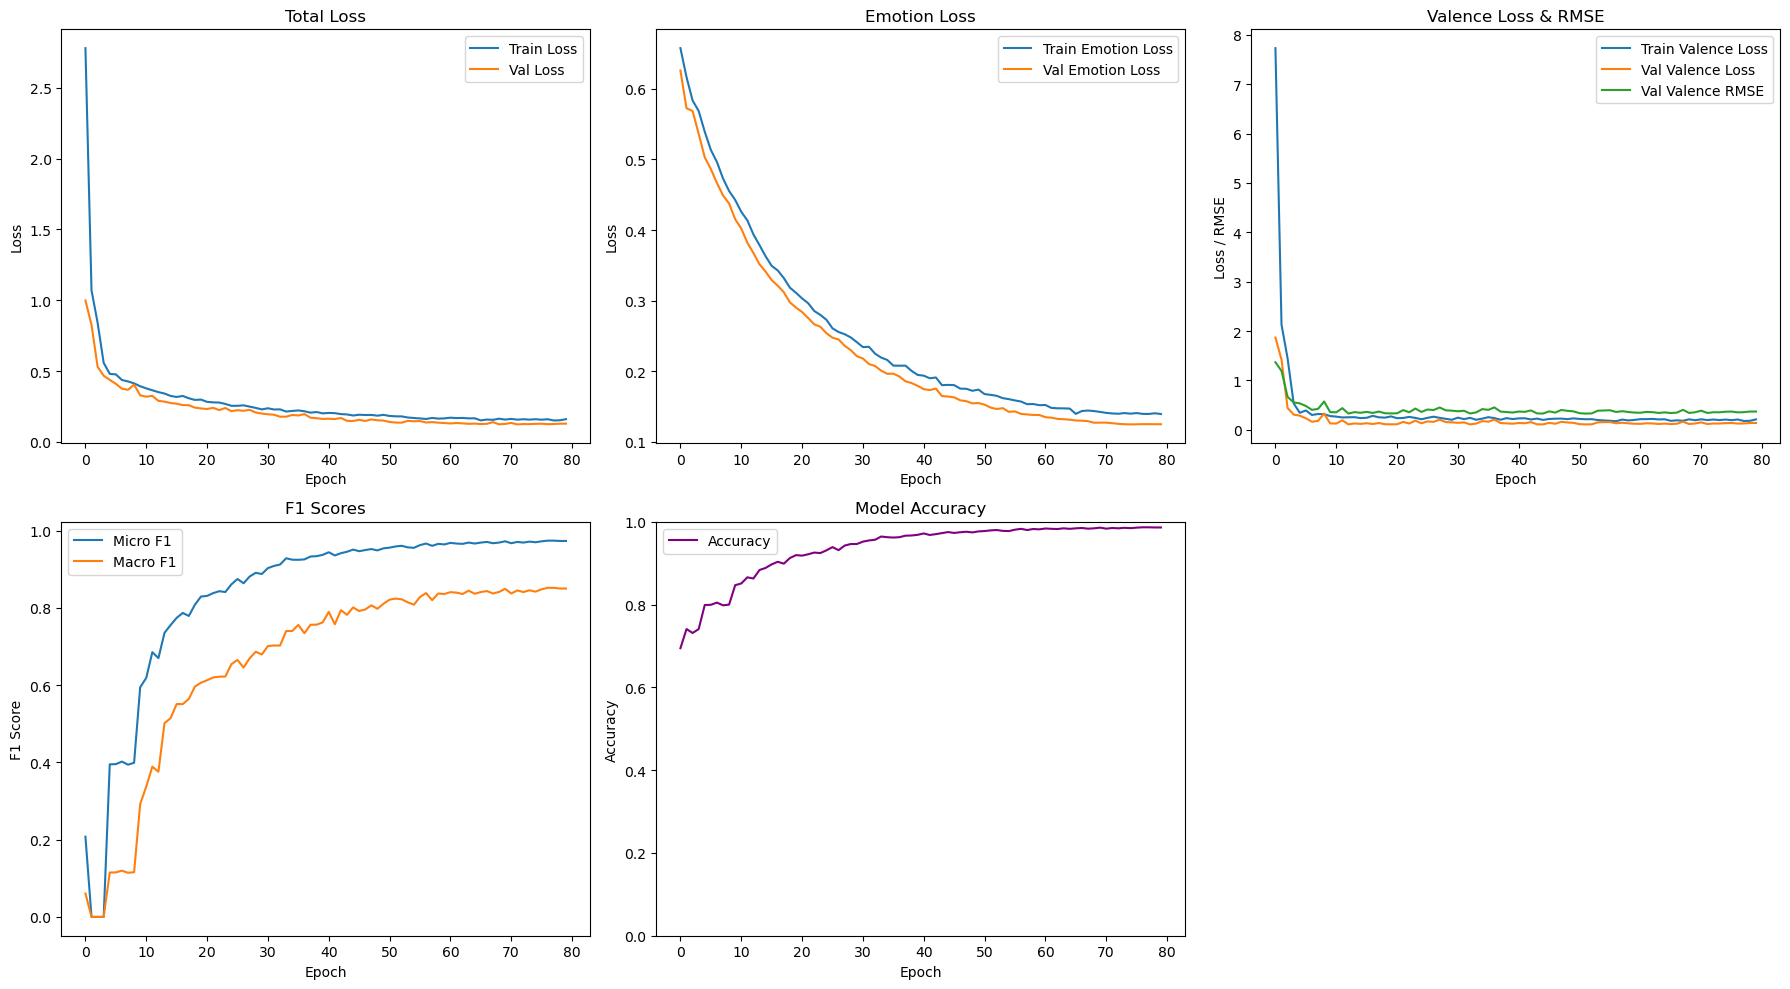

In [16]:

  # Plot the training history
def plot_training_history(history):
    # Create subplots - changed to 2x3 grid to add accuracy plot
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    
    # Plot total loss
    axs[0, 0].plot(history['train_total_loss'], label='Train Loss')
    axs[0, 0].plot(history['val_total_loss'], label='Val Loss')
    axs[0, 0].set_title('Total Loss')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()
    
    # Plot emotion loss
    axs[0, 1].plot(history['train_emotion_loss'], label='Train Emotion Loss')
    axs[0, 1].plot(history['val_emotion_loss'], label='Val Emotion Loss')
    axs[0, 1].set_title('Emotion Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend()
    
    # Plot valence loss and RMSE
    axs[0, 2].plot(history['train_valence_loss'], label='Train Valence Loss')
    axs[0, 2].plot(history['val_valence_loss'], label='Val Valence Loss')
    axs[0, 2].plot(history['val_valence_rmse'], label='Val Valence RMSE')
    axs[0, 2].set_title('Valence Loss & RMSE')
    axs[0, 2].set_xlabel('Epoch')
    axs[0, 2].set_ylabel('Loss / RMSE')
    axs[0, 2].legend()
    
    # Plot F1 scores
    axs[1, 0].plot(history['val_micro_f1'], label='Micro F1')
    axs[1, 0].plot(history['val_macro_f1'], label='Macro F1')
    axs[1, 0].set_title('F1 Scores')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('F1 Score')
    axs[1, 0].legend()
    
    # Plot accuracy
    axs[1, 1].plot(history['val_accuracy'], label='Accuracy', color='purple')
    axs[1, 1].set_title('Model Accuracy')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Accuracy')
    axs[1, 1].set_ylim([0, 1])  # Accuracy is between 0 and 1
    axs[1, 1].legend()
    
    # Hide the unused subplot
    axs[1, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'dbert_training_history.png'))
    plt.show()

# Plot the training history
plot_training_history(history)

In [17]:
# Evaluate the model on the test set
def evaluate_model(model, test_loader, emotion_criterion, valence_criterion, device):
    model.eval()
    test_emotion_loss = 0
    test_valence_loss = 0
    all_emotion_preds = []
    all_emotion_labels = []
    all_valence_preds = []
    all_valence_labels = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            emotion_labels = batch['emotion_labels'].to(device)
            valence = batch['valence'].to(device)
            
            emotion_logits, valence_pred = model(input_ids, attention_mask)
            
            e_loss = emotion_criterion(emotion_logits, emotion_labels)
            v_loss = valence_criterion(valence_pred, valence)
            
            test_emotion_loss += e_loss.item()
            test_valence_loss += v_loss.item()
            
            # Convert logits to predictions
            emotion_preds = torch.sigmoid(emotion_logits).cpu().numpy() > 0.5 
            
            all_emotion_preds.extend(emotion_preds.astype(int).tolist())
            all_emotion_labels.extend(emotion_labels.cpu().numpy().astype(int).tolist())
            all_valence_preds.extend(valence_pred.cpu().numpy().flatten().tolist())
            all_valence_labels.extend(valence.cpu().numpy().flatten().tolist())
            
    # Calculate test metrics
    avg_test_emotion_loss = test_emotion_loss / len(test_loader)
    avg_test_valence_loss = test_valence_loss / len(test_loader)
    
    # F1 scores for emotion classification
    # Convert to numpy arrays
    emotion_preds_np = np.array(all_emotion_preds)
    emotion_labels_np = np.array(all_emotion_labels)
    
    # F1 scores for multi-label emotion classification
    micro_f1 = f1_score(emotion_labels_np, emotion_preds_np, average='micro', zero_division=0)
    macro_f1 = f1_score(emotion_labels_np, emotion_preds_np, average='macro', zero_division=0)
    
    # F1 scores for each class
    class_f1 = f1_score(all_emotion_labels, all_emotion_preds, average=None)
    class_report = {emotion: score for emotion, score in zip(all_emotions, class_f1)}
    
    # RMSE for valence prediction
    valence_rmse = np.sqrt(mean_squared_error(all_valence_labels, all_valence_preds))
    
    # Calculate accuracy for multi-label classification
    accuracy = np.mean(np.array(emotion_preds_np == emotion_labels_np, dtype=float))
    
    # Create a confusion matrix for multi-label is complex
    # Instead, analyze per-class precision, recall
    results = {
        'test_emotion_loss': avg_test_emotion_loss,
        'test_valence_loss': avg_test_valence_loss,
        'test_micro_f1': micro_f1,
        'test_macro_f1': macro_f1,
        'test_valence_rmse': valence_rmse,
        'test_accuracy': accuracy,  # Added accuracy
        'class_f1': class_report
    }
    
    # Print the results
    print(f"Test Results:")
    print(f"Emotion Loss: {avg_test_emotion_loss:.4f}")
    print(f"Valence Loss: {avg_test_valence_loss:.4f}")
    print(f"Micro F1: {micro_f1:.4f}")
    print(f"Macro F1: {macro_f1:.4f}")
    print(f"Valence RMSE: {valence_rmse:.4f}")
    print(f"Accuracy: {accuracy:.4f}")  # Added accuracy print statement
    
    # Save results
    with open(os.path.join(SAVE_DIR, 'dbert_test_results.json'), 'w') as f:
        json.dump(results, f)
    
    return results

In [18]:
# Load the best model for evaluation
model.load_state_dict(torch.load(os.path.join(SAVE_DIR, 'dbert_best_model.pt')))

# Evaluate the model
test_results = evaluate_model(model, test_loader, emotion_criterion, valence_criterion, device)

print("\n")
# Print test results
'''A
print("\nTest Results:")
print(f"Emotion Loss: {test_results['test_emotion_loss']:.4f}")
print(f"Valence Loss: {test_results['test_valence_loss']:.4f}")
print(f"Micro F1: {test_results['test_micro_f1']:.4f}")
print(f"Macro F1: {test_results['test_macro_f1']:.4f}")
print(f"Valence RMSE: {test_results['test_valence_rmse']:.4f}")
print(f"Accuracy: {test_results['test_accuracy']:.4f}")
'''
print("\nClass-wise F1 Scores:")
for emotion, f1 in test_results['class_f1'].items():
    print(f"{emotion}: {f1:.4f}")

Testing:   0%|          | 0/23 [00:00<?, ?it/s]

Test Results:
Emotion Loss: 0.1274
Valence Loss: 0.1321
Micro F1: 0.9726
Macro F1: 0.8472
Valence RMSE: 0.3637
Accuracy: 0.9857



Class-wise F1 Scores:
Curiosity: 0.9924
Uncertainty: 0.9870
Excitement: 1.0000
Happiness: 0.9953
Surprise: 1.0000
Disgust: 0.9048
Fear: 0.0000
Frustration: 0.8986


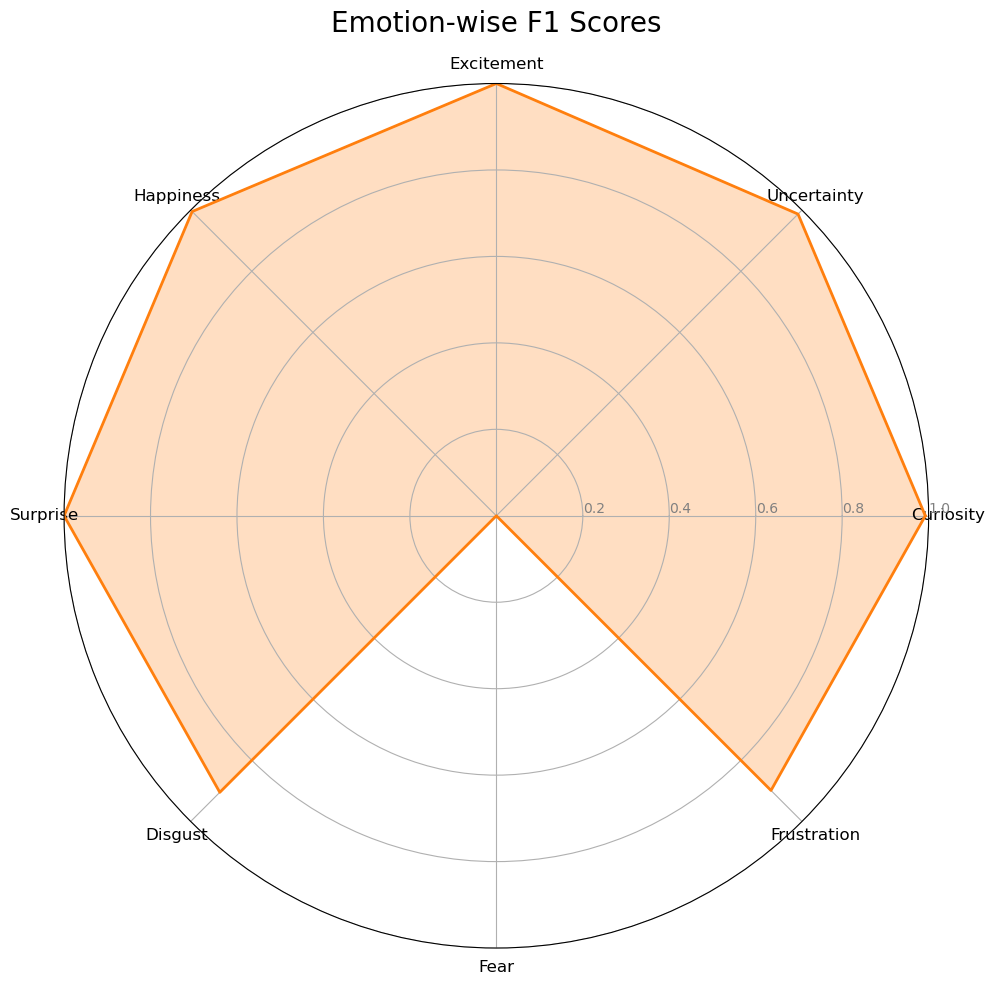

In [19]:
# Function to create and save radar chart
def create_emotion_radar_chart(class_f1, emotions, save_dir):
    # Number of variables
    N = len(emotions)
    
    # Get F1 scores in same order as emotions
    f1_scores = [class_f1[emotion] for emotion in emotions]
    
    # What will be the angle of each axis in the plot
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # F1 scores for plotting (add first element at end to close the loop)
    values = f1_scores.copy()
    values += values[:1]  
    
    # Initialize the figure
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)
    
    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], emotions, fontsize=12)
    
    # Draw the y-axis labels
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], 
               fontsize=10, color="grey")
    plt.ylim(0, 1)
    
    # Plot data
    ax.plot(angles, values, linewidth=2, linestyle='solid', color='#FF7F0E')
    
    # Fill area
    ax.fill(angles, values, alpha=0.25, color='#FF7F0E')
    
    # Add title
    plt.title("Emotion-wise F1 Scores", size=20, y=1.05)
    
    # Add grid lines
    ax.grid(True)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'dbert_emotion_F1s.png'))
    plt.show()
create_emotion_radar_chart(test_results["class_f1"], all_emotions, SAVE_DIR)

In [20]:
# Function to make predictions for a new input
def predict_emotions_and_valence(text, model, tokenizer, mlb, device):
    model.eval()
    
    # Tokenize the input text
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=512,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        emotion_logits, valence_pred = model(input_ids, attention_mask)
        
        # Convert logits to predictions
        emotion_probs = torch.sigmoid(emotion_logits).cpu().numpy()
        emotion_preds = emotion_probs > 0.5
        
        # Get the predicted emotions
        predicted_emotions = mlb.inverse_transform(emotion_preds)[0]
        
        # Get the predicted valence
        predicted_valence = valence_pred.cpu().numpy().item()
        
        # Get the probabilities for each emotion
        emotion_probabilities = {emotion: prob for emotion, prob in zip(mlb.classes_, emotion_probs[0])}
    
    return predicted_emotions, predicted_valence, emotion_probabilities


In [21]:
# Example prediction function
test_text = "I am really excited about this new movie. The trailer looks amazing and I can't wait to see it!"
predicted_emotions, predicted_valence, emotion_probs = predict_emotions_and_valence(
    test_text, model, tokenizer, mlb, device
)

print("\nExample Prediction:")
print(f"Input text: {test_text}")
print(f"Predicted emotions: {predicted_emotions}")
print(f"Predicted valence: {predicted_valence:.2f}")
print("Emotion probabilities:")
for emotion, prob in emotion_probs.items():
    print(f"{emotion}: {prob:.4f}")


Example Prediction:
Input text: I am really excited about this new movie. The trailer looks amazing and I can't wait to see it!
Predicted emotions: ('Excitement', 'Happiness')
Predicted valence: 5.51
Emotion probabilities:
Curiosity: 0.1380
Uncertainty: 0.0585
Excitement: 0.7559
Happiness: 0.8053
Surprise: 0.1171
Disgust: 0.0258
Fear: 0.0167
Frustration: 0.0483


In [22]:

# Save the complete model, tokenizer, and configuration
model_save_path = os.path.join(SAVE_DIR, 'dbert')
os.makedirs(model_save_path, exist_ok=True)

# Save model configuration
model_config = {
    'model_name': 'distilbert-base-uncased',
    'n_emotions': len(all_emotions),
    'emotions': all_emotions,
    'valence_range': [df['Valence'].min(), df['Valence'].max()],
    'max_length': 512,
}

with open(os.path.join(model_save_path, 'config.json'), 'w') as f:
    json.dump(model_config, f)

# Save the model state
torch.save(model.state_dict(), os.path.join(model_save_path, 'model_state.pt'))

# Save tokenizer
tokenizer.save_pretrained(model_save_path)

print(f"\nModel, tokenizer, and configuration saved to {model_save_path}")



Model, tokenizer, and configuration saved to /Users/rumenguin/Research/MERC/models/saved_model/dbert


In [23]:
# Final messages
print("\nTraining completed successfully!")
print(f"Best model saved to: {os.path.join(SAVE_DIR, 'dbert_best_model.pt')}")
print(f"Final model saved to: {os.path.join(SAVE_DIR, 'dbert_final_model.pt')}")
print(f"Complete model package saved to: {model_save_path}")
print(f"Training history plot saved to: {os.path.join(SAVE_DIR, 'dbert_training_history.png')}")
print(f"Training history saved to: {os.path.join(SAVE_DIR, 'dbert_training_history.json')}")
print(f"Test results saved to: {os.path.join(SAVE_DIR, 'dbert_test_results.json')}")


Training completed successfully!
Best model saved to: /Users/rumenguin/Research/MERC/models/saved_model/dbert_best_model.pt
Final model saved to: /Users/rumenguin/Research/MERC/models/saved_model/dbert_final_model.pt
Complete model package saved to: /Users/rumenguin/Research/MERC/models/saved_model/dbert
Training history plot saved to: /Users/rumenguin/Research/MERC/models/saved_model/dbert_training_history.png
Training history saved to: /Users/rumenguin/Research/MERC/models/saved_model/dbert_training_history.json
Test results saved to: /Users/rumenguin/Research/MERC/models/saved_model/dbert_test_results.json
